In [1]:
import statistics
from datetime import timedelta

import holidays
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
import pickle


In [62]:
data = pd.read_csv("../data/train_imputed.csv", index_col=0, parse_dates=True)
# data = data.iloc[data.shape[0]//2:, :]  # to keep only latest data, after large batch of missing values

In [63]:
pollutants = data.columns.to_list()

In [64]:
weather = pd.read_csv("../data/paris_weather_extensive.csv", index_col=0, parse_dates=True)

In [65]:
data.index = data.index.tz_localize(None)
weather.index = weather.index.tz_localize(None)


full_index = pd.date_range(start=weather.index.min(), end=weather.index.max(), freq="H")
weather = weather.reindex(full_index)

# 2. Interpolate the missing values
weather = weather.interpolate(method="linear")

data = data.merge(weather, how="left", left_index=True, right_index=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_86592\454962465.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=weather.index.min(), end=weather.index.max(), freq="H")


# Data Prep

In [66]:
def preprocess_time_series(
    data, target_pollutant, pollutants, weather_data=None, traffic_data=None
):
    # Basic Time Features
    data["hour"] = data.index.hour
    data["day"] = data.index.day
    data["day_of_week"] = data.index.dayofweek
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["is_weekend"] = (data["day_of_week"] >= 5).astype(int)

    # Cyclical encoding
    data["sin_hour"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["cos_hour"] = np.cos(2 * np.pi * data["hour"] / 24)
    data["sin_day"] = np.sin(2 * np.pi * data.index.dayofyear / 365)
    data["cos_day"] = np.cos(2 * np.pi * data.index.dayofyear / 365)

    # French Holidays
    fr_holidays = holidays.France(years=data.index.year.unique())
    data["is_holiday"] = data.index.isin(fr_holidays).astype(int)

    data = pd.get_dummies(data, columns=["day_of_week"], drop_first=True, dtype=int)

    data = data.fillna(method="ffill")

    return data

In [67]:
data = preprocess_time_series(data, None, None)

C:\Users\nicol\AppData\Local\Temp\ipykernel_86592\1480426689.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_holiday"] = data.index.isin(fr_holidays).astype(int)
C:\Users\nicol\AppData\Local\Temp\ipykernel_86592\1480426689.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


# Modeling

## CatBoost

In [68]:
def train_catboost_time_series(data, target, test_period="3W", params=None):
    """
    Train a CatBoost model for time series forecasting with optional parameter tuning.

    Parameters:
    - data: DataFrame containing features and target.
    - target: The name of the target pollutant.
    - test_period: Duration of the test set (default is "3W").
    - params: Dictionary of parameters to use for the CatBoost model (optional).

    Returns:
    - model: The trained CatBoost model.
    - mae: Mean Absolute Error of the model on the test set.
    """
    
    ext_features = data.columns[~data.columns.str.startswith("valeur")].tolist()

    data = data[[target] + ext_features]

    # Split data into training and test sets chronologically
    test_end = data.index[-1]
    test_start = test_end - pd.Timedelta(test_period)
    train_data = data[data.index < test_start]
    test_data = data[(data.index >= test_start) & (data.index <= test_end)]

    X_train, y_train = train_data.drop(columns=[target]), train_data[target]
    X_test, y_test = test_data.drop(columns=[target]), test_data[target]

    if params is not None:
        model = CatBoostRegressor(
            iterations=params.get('iterations', 1000),
            learning_rate=params.get('learning_rate', 0.1),
            depth=params.get('depth', 6),
            loss_function="MAE",
            random_seed=42,
            verbose=100,
        )
    else:
        param_grid = {
            'iterations': [500],
            'learning_rate': [0.05, 0.1],
            'depth': [4, 6, 8]
        }

        best_mae = np.inf
        best_model = None
        best_params = {}

        # Grid search for hyperparameter tuning
        for iterations in param_grid['iterations']:
            for learning_rate in param_grid['learning_rate']:
                for depth in param_grid['depth']:
                    model = CatBoostRegressor(
                        iterations=iterations,
                        learning_rate=learning_rate,
                        depth=depth,
                        loss_function="MAE",
                        random_seed=42,
                        verbose=0,
                    )

                    # Train
                    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

                    # Predict
                    predictions = model.predict(X_test)

                    mae = mean_absolute_error(y_test, predictions)
                    print(f"Evaluated MAE for params: iterations={iterations}, learning_rate={learning_rate}, depth={depth}: {mae}")

                    if mae < best_mae:
                        best_mae = mae
                        best_model = model
                        best_params = {'iterations': iterations, 'learning_rate': learning_rate, 'depth': depth}

        print(f"Best parameters: {best_params} with MAE: {best_mae}")

        with open(f"../models/best_catboost_{target}.pkl", "wb") as f:
            pickle.dump(best_model, f)

        model = best_model

    # Train
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

    # Make final predictions
    final_predictions = model.predict(X_test)

    final_mae = mean_absolute_error(y_test, final_predictions)
    print(f"Mean Absolute Error (MAE) for {target}: {final_mae}")

    return model, final_mae


In [69]:
def train_catboost_time_series_feature_importances(data, target, test_period="3W", params=None, top_feature_fraction=0.5):
    """
    Train a CatBoost model for time series forecasting with optional parameter tuning and feature selection.
    
    Parameters:
    - data: DataFrame containing features and target.
    - target: The name of the target column.
    - test_period: Duration of the test set (default is "3W").
    - params: Dictionary of parameters to use for the CatBoost model (optional).
    - top_feature_fraction: Fraction of top features to retain based on importance (default is 0.2).
    
    Returns:
    - model: The trained CatBoost model.
    - mae: Mean Absolute Error of the model on the test set.
    """
    
    ext_features = data.columns[~data.columns.str.startswith("valeur")].tolist()
    data = data[[target] + ext_features]

    # Split data into training and test sets chronologically
    test_end = data.index[-1]
    test_start = test_end - pd.Timedelta(test_period)
    train_data = data[data.index < test_start]
    test_data = data[(data.index >= test_start) & (data.index <= test_end)]

    X_train, y_train = train_data.drop(columns=[target]), train_data[target]
    X_test, y_test = test_data.drop(columns=[target]), test_data[target]

    if params is None:
        param_grid = {
            'iterations': [500],
            'learning_rate': [0.05, 0.1],
            'depth': [4, 6, 8]
        }

        best_mae = np.inf
        best_model = None
        best_params = {}

        # Grid search for hyperparameter tuning
        for iterations in param_grid['iterations']:
            for learning_rate in param_grid['learning_rate']:
                for depth in param_grid['depth']:
                    model = CatBoostRegressor(
                        iterations=iterations,
                        learning_rate=learning_rate,
                        depth=depth,
                        loss_function="MAE",
                        random_seed=42,
                        verbose=0,
                    )

                    # Train
                    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

                    # Predict
                    predictions = model.predict(X_test)
                    mae = mean_absolute_error(y_test, predictions)
                    print(f"Evaluated MAE for params: iterations={iterations}, learning_rate={learning_rate}, depth={depth}: {mae}")

                    if mae < best_mae:
                        best_mae = mae
                        best_model = model
                        best_params = {'iterations': iterations, 'learning_rate': learning_rate, 'depth': depth}

        print(f"Best parameters: {best_params} with MAE: {best_mae}")
        model = best_model

        # Save best model
        with open(f"../models/best_catboost_{target}.pkl", "wb") as f:
            pickle.dump(model, f)
    else:
        model = CatBoostRegressor(
            iterations=params.get('iterations', 1000),
            learning_rate=params.get('learning_rate', 0.1),
            depth=params.get('depth', 6),
            loss_function="MAE",
            random_seed=42,
            verbose=100,
        )

    # Train best_model
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

    # Calculate feature importances and select top features
    feature_importances = model.get_feature_importance()
    feature_ranking = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
    top_features = [f[0] for f in feature_ranking[:int(len(feature_ranking) * top_feature_fraction)]]

    # Retrain model on top features only
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]
    model.fit(X_train_top, y_train, eval_set=(X_test_top, y_test), early_stopping_rounds=50)

    # Final predictions
    final_predictions = model.predict(X_test_top)
    final_mae = mean_absolute_error(y_test, final_predictions)
    print(f"Mean Absolute Error (MAE) for {target} with top {int(top_feature_fraction * 100)}% features: {final_mae}")

    return model, final_mae


In [43]:
def train_prophet_and_catboost(data, target_pollutant, test_period="3W"):

    test_end = data.index[-1]
    test_start = test_end - pd.Timedelta(test_period)
    train_data = data[data.index < test_start]
    test_data = data[(data.index >= test_start) & (data.index <= test_end)]

    # Prepare data for Prophet
    prophet_data = data[[target_pollutant]].reset_index()
    prophet_data.columns = ["ds", "y"]

    # Split data into training and test sets
    test_size = len(test_data)
    test_data = prophet_data[-test_size:]
    prophet_data = prophet_data[:-test_size]

    model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
    model.add_seasonality(name="monthly", period=30.5, fourier_order=5)

    model.fit(prophet_data)

    # Generate future dates for the forecast
    future_dates = model.make_future_dataframe(periods=test_size, freq="H")  # 21 days hourly
    forecast = model.predict(future_dates)

    mse = mean_absolute_error(test_data.y, forecast[-test_size:]['yhat'])
    print(f"MAE for {target_pollutant}: {mse}")

    # Calculate residuals
    residuals = test_data['y'].values - forecast['yhat'][-test_size:].values

    # Prepare data for CatBoost
    ext_features = data.columns[~data.columns.str.startswith("valeur")].tolist()
    X_train_residuals = data[:-test_size][ext_features]
    y_train_residuals = residuals

    # Train CatBoost on the residuals
    catboost_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function="MAE",
        random_seed=42,
        verbose=100,
    )

    catboost_model.fit(X_train_residuals, y_train_residuals)

    # Make predictions on the test set using the CatBoost model
    X_test_residuals = data[-test_size:][ext_features]
    residual_predictions = catboost_model.predict(X_test_residuals)

    # Combine predictions
    final_predictions = forecast['yhat'][-test_size:].values + residual_predictions

    # Evaluate the final predictions
    final_mae = mean_absolute_error(test_data['y'], final_predictions)
    print(f"Final MAE for combined predictions: {final_mae}")

    return model, catboost_model, final_predictions, final_mae


In [55]:
data

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,apparent_temperature,cloud_cover,cloud_cover_high,cloud_cover_low,cloud_cover_mid,...,cos_hour,sin_day,cos_day,is_holiday,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
id,,,,,,,,,,,,,,,,,,,,,
2022-05-03 23:00:00,14.600000,0.214883,56.9,26.900000,18.100000,8.547590,57.000004,0.0,0.0,95.0,...,9.659258e-01,0.854322,-0.519744,0,1,0,0,0,0,0
2022-05-04 00:00:00,13.700000,0.228473,55.2,24.000000,18.400000,8.306509,54.600002,4.0,0.0,89.0,...,1.000000e+00,0.845249,-0.534373,0,0,1,0,0,0,0
2022-05-04 01:00:00,11.500000,0.211464,57.2,28.800000,19.800000,8.449738,65.099998,19.0,0.0,99.0,...,9.659258e-01,0.845249,-0.534373,0,0,1,0,0,0,0
2022-05-04 02:00:00,12.100000,0.231801,54.3,24.200000,19.400000,8.484323,66.000000,22.0,0.0,99.0,...,8.660254e-01,0.845249,-0.534373,0,0,1,0,0,0,0
2022-05-04 03:00:00,13.700000,0.164921,52.5,15.055887,8.507635,7.799820,86.400009,88.0,0.0,100.0,...,7.071068e-01,0.845249,-0.534373,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-03 18:00:00,24.737806,0.222000,55.1,12.000000,5.300000,19.869907,38.700001,100.0,3.0,10.0,...,-1.836970e-16,-0.895839,-0.444378,0,1,0,0,0,0,0
2024-09-03 19:00:00,26.877610,0.245000,48.2,13.400000,7.000000,18.508705,33.300003,100.0,1.0,4.0,...,2.588190e-01,-0.895839,-0.444378,0,1,0,0,0,0,0
2024-09-03 20:00:00,24.648191,0.234000,44.5,12.400000,7.100000,16.772964,42.300003,100.0,13.0,1.0,...,5.000000e-01,-0.895839,-0.444378,0,1,0,0,0,0,0


In [54]:
mae_dict = {}
model_dict = {}

params = {
    'iterations': [500],
    'learning_rate': [0.1],
    'depth': [8]
}

for target_pollutant in pollutants:

    model, mae = train_catboost_time_series_feature_importances(data, target_pollutant, params=None)

    mae_dict[target_pollutant] = mae
    model_dict[target_pollutant] = model


expected_score = statistics.mean(mae_dict.values())

print(f"The average MAE between pollutants is: {expected_score}")

Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=4: 5.685695689733501
Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=6: 5.641807420248975
Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=8: 5.71134207892686
Evaluated MAE for params: iterations=500, learning_rate=0.1, depth=4: 5.738260329772755
Evaluated MAE for params: iterations=500, learning_rate=0.1, depth=6: 5.4205862998313075
Evaluated MAE for params: iterations=500, learning_rate=0.1, depth=8: 5.501529294397283
Best parameters: {'iterations': 500, 'learning_rate': 0.1, 'depth': 6} with MAE: 5.4205862998313075
Mean Absolute Error (MAE) for valeur_NO2 with top 100% features: 6.014364630983595
Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=4: 0.026766359420773458
Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=6: 0.02710220373685266
Evaluated MAE for params: iterations=500, learning_rate=0.05, depth=8: 0.025794080005068956
Evaluated M

In [56]:
for p in pollutants:
    print(p, ":", model_dict[p].get_params())

valeur_NO2 : {'iterations': 500, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0}
valeur_CO : {'iterations': 500, 'learning_rate': 0.1, 'depth': 8, 'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0}
valeur_O3 : {'iterations': 500, 'learning_rate': 0.05, 'depth': 6, 'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0}
valeur_PM10 : {'iterations': 500, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0}
valeur_PM25 : {'iterations': 500, 'learning_rate': 0.1, 'depth': 4, 'loss_function': 'MAE', 'random_seed': 42, 'verbose': 0}


# Prepare Sub

In [57]:
sub = pd.read_csv("../data/test.csv", index_col=0, parse_dates=True)

In [58]:
sub = sub.merge(weather, how="left", right_index=True, left_index=True)

In [59]:
sub = preprocess_time_series(sub, None, None)

C:\Users\nicol\AppData\Local\Temp\ipykernel_86592\1480426689.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data["is_holiday"] = data.index.isin(fr_holidays).astype(int)
C:\Users\nicol\AppData\Local\Temp\ipykernel_86592\1480426689.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


In [60]:
results = {}
results["id"] = sub.index.strftime("%Y-%m-%d %H")

for target_pollutant in pollutants:
    model = model_dict[target_pollutant]
    pred = model.predict(sub)
    results[target_pollutant] = pred

results_df = pd.DataFrame(results).set_index("id")

In [61]:
results_df.to_csv("../submissions/prediction_5.csv")

# Other models

## Prophet

18:39:24 - cmdstanpy - INFO - Chain [1] start processing
18:39:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_NO2: 9.531878169096737


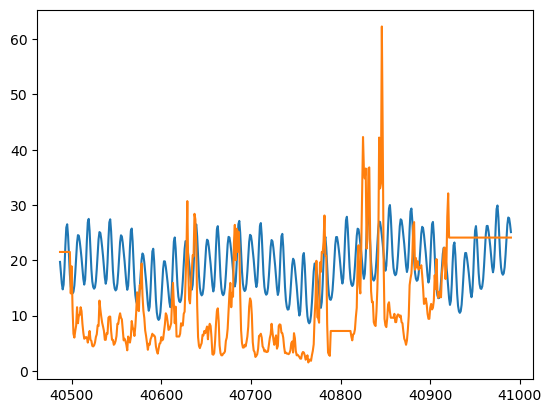

18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_CO: 0.04040603205391269


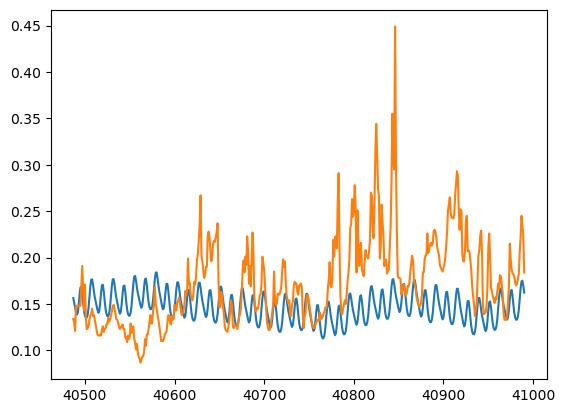

18:40:09 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_O3: 12.739431779330898


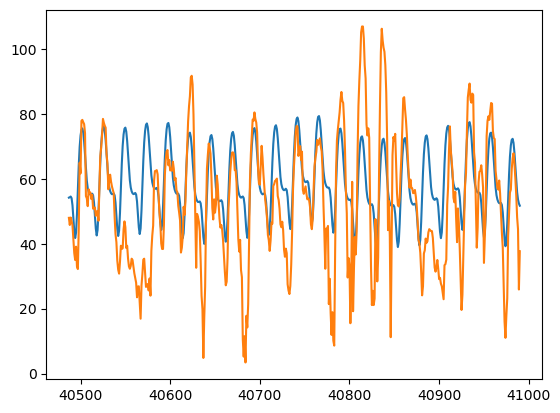

18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_PM10: 5.511321080265332


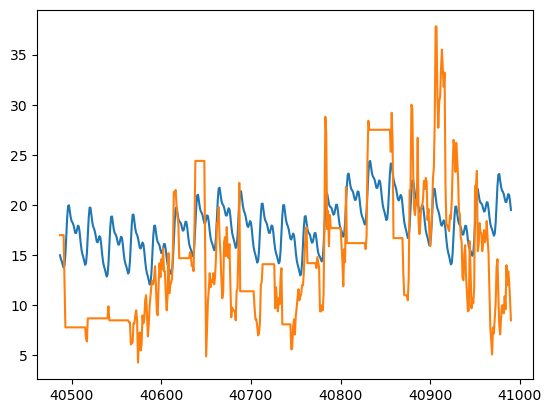

18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_PM25: 3.264815762053901


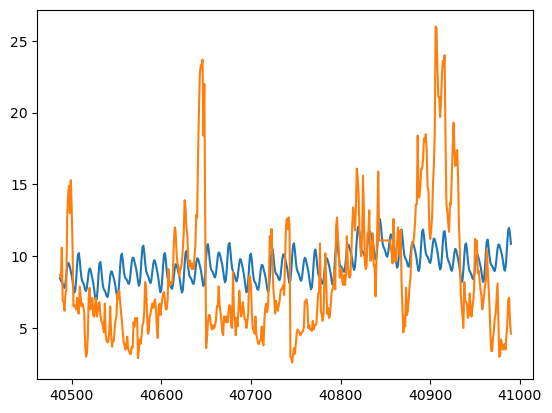

In [9]:
for target_pollutant in pollutants:

    # Prepare data
    prophet_data = data[[target_pollutant]].reset_index()
    prophet_data.columns = ["ds", "y"]

    test_size = 24 * 21
    test_data = prophet_data[-test_size:]
    prophet_data = prophet_data[:-test_size]

    model = Prophet(
        daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True
    )

    model.add_seasonality(name="monthly", period=30.5, fourier_order=5)
    # model.add_seasonality(name='seasonal', period=90, fourier_order=3)
    # model.add_seasonality(name='yearly', period=365, fourier_order=10)

    # Fit
    model.fit(prophet_data)

    future_dates = model.make_future_dataframe(
        periods=21 * 24, freq="H"
    )

    forecast = model.predict(future_dates)

    print(
        f"mse for {target_pollutant}: {mean_absolute_error(test_data.y, forecast[-24*21:].yhat)}"
    )

    plt.plot(forecast[-24 * 21 :].yhat)
    plt.plot(test_data.y)
    plt.show()

18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\nicol\anaconda3\envs\timeseries\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


mse for valeur_PM25: 3.2476755101864674


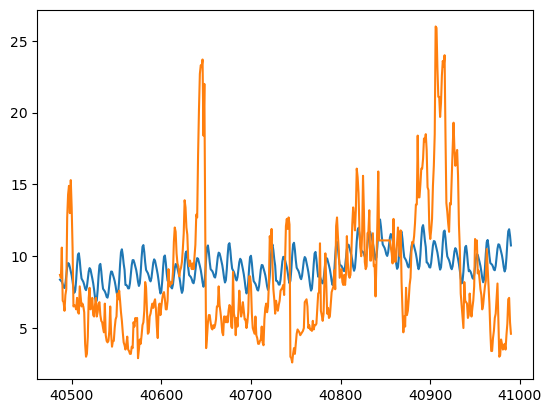

In [14]:
prophet_data = data[[target_pollutant]].reset_index()
prophet_data.columns = ["ds", "y"]

test_size = 24 * 21
test_data = prophet_data[-test_size:]
prophet_data = prophet_data[:-test_size]

prophet_data["day_of_week"] = prophet_data["ds"].dt.dayofweek
prophet_data["is_weekend"] = (
    prophet_data["day_of_week"].isin([5, 6]).astype(int)
)

country_holidays = holidays.CountryHoliday(
    "FR"
)

holiday_dates = pd.DataFrame(
    {
        "holiday": "holiday",
        "ds": pd.to_datetime(list(country_holidays.keys())),
        "lower_window": 0,
        "upper_window": 1,
    }
)

model = Prophet(
    daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True
)

model.add_seasonality(name="monthly", period=30.5, fourier_order=5)

model.add_regressor("day_of_week")
model.add_regressor("is_weekend")

model.fit(prophet_data)

future = model.make_future_dataframe(
    periods=21 * 24, freq="H"
)

future["day_of_week"] = future["ds"].dt.dayofweek
future["is_weekend"] = future["day_of_week"].isin([5, 6]).astype(int)

forecast = model.predict(future)

print(
    f"mse for {target_pollutant}: {mean_absolute_error(test_data.y, forecast[-24*21:].yhat)}"
)

plt.plot(forecast[-24 * 21 :].yhat)
plt.plot(test_data.y)
plt.show()

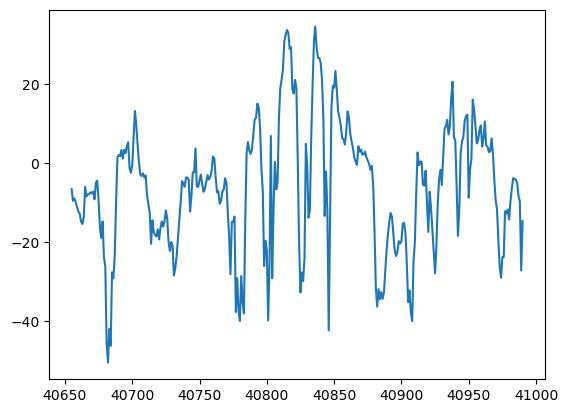

In [44]:
residuals = test_data.y - forecast[-24 * 14 :].yhat

plt.plot(residuals)
plt.show()

In [1]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

plot_components_plotly(model, forecast)

NameError: name 'model' is not defined